In [47]:
from pathlib import Path
import re, numpy as np, torch
import pandas as pd
import mne
from braindecode.models import EEGNet, ShallowFBCSPNet
from braindecode.util import set_random_seeds
from braindecode.datasets import create_from_mne_epochs
from braindecode.preprocessing import create_fixed_length_windows
from braindecode.training import CroppedLoss
from torch import nn
from torch.utils.data import DataLoader


In [48]:
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  

DATA = Path(f"{parentPath}/data")
DER  = DATA / "derivatives"  
FIGS = Path(f"{parentPath}/figs"); FIGS.mkdir(parents=True, exist_ok=True)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("ERROR")

In [49]:

paths = sorted(DER.glob("*-epo.fif"))
paths = [p for p in paths if re.search(r"R(04|08|12)", p.name)]  # L/R imagery only

In [50]:
list_of_epochs = []
runs, subjects = [], []
for p in paths:

    ep = mne.read_epochs(p, preload=True, verbose=False)

    if len(ep)==0: continue
    run = int(re.search(r"R(\d{2})", p.name).group(1)); runs.extend([run]*len(ep))
    subj_name = re.search(r"(S\d{3})", p.name).group(1); subj_number = int(subj_name.lstrip("S")); subjects.extend([subj_number] * len(ep))
    list_of_epochs.append(ep)
runs = np.array(runs); subjects = np.array(subjects)

In [51]:
# Load & prepare dataset for Braindecode models
n_times = len(list_of_epochs[0].times)  # samples per epoch
windows_dataset = create_from_mne_epochs(
    list_of_epochs,                 # API expects a list of Epochs
    window_size_samples=n_times,    # full-epoch window
    window_stride_samples=n_times,  # stride=length -> 1 window/epoch
    drop_last_window=True,          # drop incomplete window
)

# Inspect an element
X_shape = windows_dataset[0][0].shape  # (channels, time)
y = meta["target"].to_numpy().astype(int)

meta  = pd.concat([ds.windows.metadata for ds in windows_dataset.datasets], ignore_index=True)
n_classes = meta["target"].nunique()
print("Shape per trial:", X_shape, "Classes:", n_classes)



Shape per trial: (64, 161) Classes: 2


In [69]:
# Train small models
from braindecode import EEGClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import EarlyStopping

device = 'cuda' if torch.cuda.is_available() else 'cpu'
eegnet_dl = EEGClassifier(
    eegnet,
    cropped=False,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=ValidSplit(cv=0.2, random_state=42),
    batch_size=32,
    max_epochs=50,
    # callbacks=[('es', EarlyStopping(patience=5))],
    device=device,
)
shallow_dl = EEGClassifier(
    shallow,    
    cropped=False,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=ValidSplit(cv=0.2, random_state=42),
    batch_size=32,
    max_epochs=50,
    # callbacks=[('es', EarlyStopping(patience=5))],
    device=device,
)
eegnet_dl.fit(windows_dataset, y=meta["target"].values)
shallow_dl.fit(windows_dataset, y=meta["target"].values)



  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2607       0.6497        1.1225  4.1580
      2        0.2085       0.7109        0.8731  3.7030
      3        0.2233       0.7381        0.8937  3.2970
      4        0.2265       0.6803        0.8282  3.2708
      5        0.1940       0.6735        1.0281  3.2545
      6        0.1978       0.6531        1.3881  3.2542
      7        0.2281       0.6939        1.1389  3.3044
      8        0.2166       0.5816        2.5360  3.2257
      9        0.2234       0.5442        3.8754  3.2998
     10        0.1903       0.7211        0.9818  3.2999
     11        0.2093       0.7415        0.7375  3.2330
     12        0.1998       0.7007        1.1187  3.3500
     13        0.1894       0.7381        0.6683  3.3794
     14        0.2012       0.7041        1.0233  3.2573
     15        0.1955       0.7449        0.7652  3.2656
     16        0.1857       0.7

,module,EEGNet( (en...') ) ) )
,criterion,<class 'torch...sEntropyLoss'>
,cropped,False
,callbacks,None
,iterator_train__shuffle,True
,iterator_train__drop_last,True
,aggregate_predictions,True
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.01
,max_epochs,50
,batch_size,32


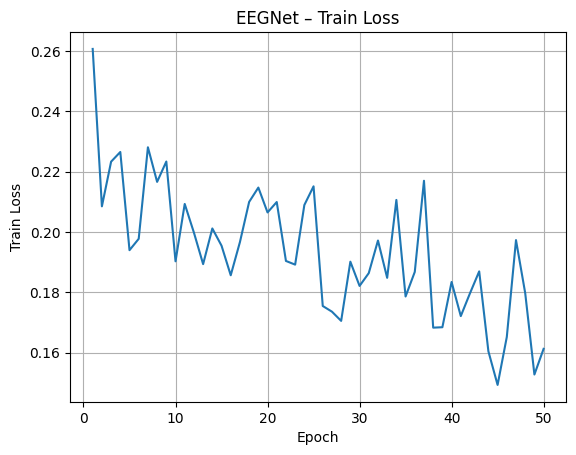

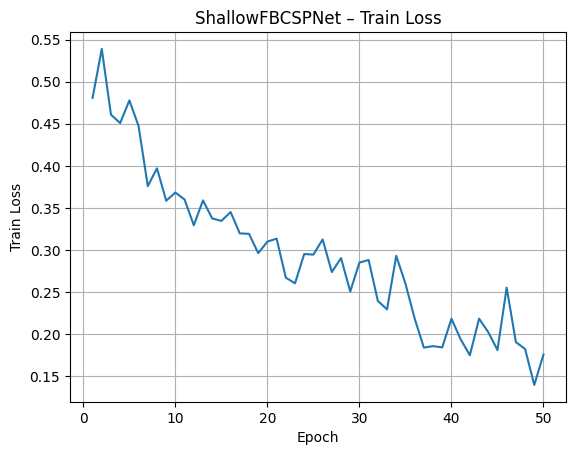

In [70]:
import matplotlib.pyplot as plt

def _as_list(h, key):
    """Return history column `key` as a python list if it exists, else None."""
    try:
        return [row[key] for row in h] if key in h[0] else None
    except Exception:
        # skorch History behaves like a list of dicts
        try:
            return h[:, key]
        except Exception:
            return None

def plot_history(clf, title_prefix="Model"):
    """
    clf: a fitted EEGClassifier (e.g., eegnet_dl or shallow_dl)
    Plots train_loss, valid_loss, valid_acc (if present).
    """
    hist = clf.history_
    epochs = _as_list(hist, "epoch")
    train_loss = _as_list(hist, "train_loss")
    valid_loss = _as_list(hist, "valid_loss")
    valid_acc  = _as_list(hist, "valid_acc")

    if epochs is None:
        print(f"{title_prefix}: no history found.")
        return

    # Train loss
    if train_loss is not None:
        plt.figure()
        plt.plot(epochs, train_loss)
        plt.xlabel("Epoch")
        plt.ylabel("Train Loss")
        plt.title(f"{title_prefix} – Train Loss")
        plt.grid(True)
        plt.show()

    # # Valid loss
    # if valid_loss is not None:
    #     plt.figure()
    #     plt.plot(epochs, valid_loss)
    #     plt.xlabel("Epoch")
    #     plt.ylabel("Valid Loss")
    #     plt.title(f"{title_prefix} – Validation Loss")
    #     plt.grid(True)
    #     plt.show()
    # else:
    #     print(f"{title_prefix}: no validation loss (train_split=None).")

    # # Valid accuracy
    # if valid_acc is not None:
    #     plt.figure()
    #     plt.plot(epochs, valid_acc)
    #     plt.xlabel("Epoch")
    #     plt.ylabel("Valid Accuracy")
    #     plt.title(f"{title_prefix} – Validation Accuracy")
    #     plt.grid(True)
    #     plt.show()
    # else:
    #     print(f"{title_prefix}: no validation accuracy (train_split=None).")

# Plot both models
plot_history(eegnet_dl, title_prefix="EEGNet")
plot_history(shallow_dl, title_prefix="ShallowFBCSPNet")


In [71]:
y_pred_eegnet = eegnet_dl.predict(windows_dataset)
y_pred_shallow = shallow_dl.predict(windows_dataset)
from sklearn.metrics import accuracy_score, cohen_kappa_score
print("EEGNet acc:", accuracy_score(y, y_pred_eegnet))
print("EEGNet κ:", cohen_kappa_score(y, y_pred_eegnet))
print("ShallowFBCSPNet acc:", accuracy_score(y, y_pred_shallow))
print("ShallowFBCSPNet κ:", cohen_kappa_score(y, y_pred_shallow))


EEGNet acc: 0.8049113233287858
EEGNet κ: 0.6111427474388487
ShallowFBCSPNet acc: 0.4945429740791269
ShallowFBCSPNet κ: 0.0


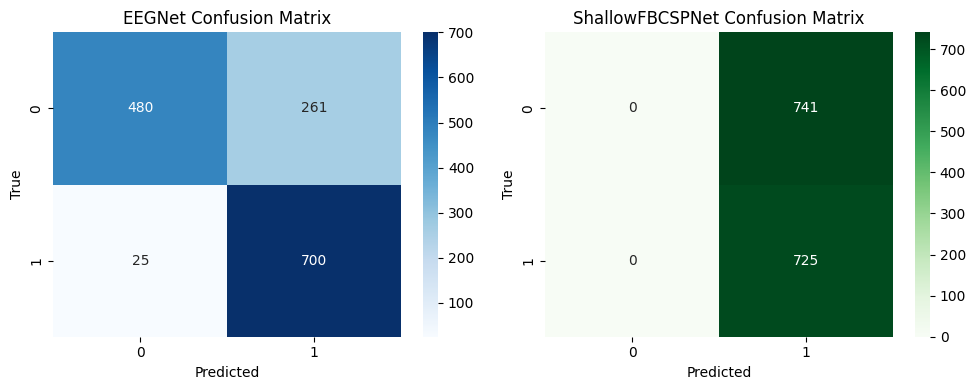

In [72]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm_eegnet = confusion_matrix(y, y_pred_eegnet)
cm_shallow = confusion_matrix(y, y_pred_shallow)
f, ax = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(cm_eegnet, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('EEGNet Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
sns.heatmap(cm_shallow, annot=True, fmt='d', ax=ax[1], cmap='Greens')
ax[1].set_title('ShallowFBCSPNet Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
plt.tight_layout()
plt.show()#savefig(FIGS / "confusion_matrices.png", dpi=300)   